In [1]:
import os
import tkinter as tk
from tkinter import filedialog
from math import*
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

class MouseDailyRecord:
    def __init__(self, _mouseInd, _MainDfs, _config, _trialPerGroup):
        self.Days = []

        self.mouseInd = _mouseInd
        self.MainDfs = _MainDfs
        self.configs = _config
        self.trialPerGroup = _trialPerGroup

        for day in range(0, len(self.MainDfs)):
            self.Days.append(self.Day(self.MainDfs[day], self.mouseInd, day))
        for day in self.Days:
            day.Process()    

    def ReturnResults(self):
        _tempResultsEveryDay = []
        for day in self.Days:
            _tempResultsEveryDay.append(day.ReturnResults())
        return _tempResultsEveryDay
    
    def ReturnAccuracyInGroup(self):
        _tempResultsInGroupEveryDay = []
        for day in self.Days:
            _tempResultsInGroupEveryDay.append(day.ReturnAccuracyInGroup())
        return _tempResultsInGroupEveryDay
    
    def ReturnSpout(self):
        _tempLickPosEveryDay = []
        for day in self.Days:
            _tempLickPosEveryDay.append(day.ReturnSpout())
        return _tempLickPosEveryDay
    
    def ReturnRightSpout(self):
        _tempRightLickPosEveryDay = []
        for day in self.Days:
            _tempRightLickPosEveryDay.append(day.ReturnRightSpout())
        return _tempRightLickPosEveryDay
    
    def ReturnMean(self):
        _tempMean = []
        for day in self.Days:
            _tempMean.append(day.ReturnMean())
        return _tempMean


    class Day:
        def __init__(self, _MainDf, _name, _day):
            self.trials                  = []
            self.startIndices            = []
            self.EndIndices              = []
            self.licks                   = []
            self.licksPos                = []
            self.lickInterval            = []
            self.lickIntervalLog         = []
            self.trialResults            = []
            self.trialElapsedTime        = []
            self.trialIntervalTime       = []
            self.trialAccuracyInGroup    = []
            self.trialElapsedTimeInGroup = []
            self.trialIntervalInGroup    = []

            self.MainDf = _MainDf
            self.trialPerGroup = -1
            self.day = _day
            self.name = _name

        def Process(self): 
            init = self.MainDf.index[self.MainDf['type'] == "init"]
            if (len(init)):
                init = max(init)
            else:
                init = 0
            self.MainDf = self.MainDf[init:]

            self.startIndices    =          self.MainDf.index[self.MainDf['type'] == "start"]#trial处理均以开始结束Index为标准
            self.EndIndices      =          self.MainDf.index[self.MainDf['type'] == "end"]
            self.licks           = np.array(self.MainDf.loc[self.MainDf["type"] == "lick"]["delta time"])
            self.startIndices.delete(range(len(self.EndIndices), len(self.startIndices)))
            
            for i in range(1, len(self.startIndices)):
                self.trials.append(             self.MainDf.loc[self.startIndices[i-1] : self.startIndices[i], :])
                tempResult:int = int(self.trials[i - 1].loc[self.EndIndices[i - 1]]["result"])
                if tempResult >= 0:
                    self.licksPos.append(           self.trials[i - 1].loc[self.EndIndices[i - 1] - 1]["lickPos"])
                    self.trialResults.append(       self.trials[i - 1].loc[self.EndIndices[i - 1]]["result"])
                    self.trialElapsedTime.append(   self.trials[i - 1].loc[self.EndIndices[i-1]]['delta time'] - self.trials[i - 1].loc[self.startIndices[i-1]]['delta time'])
                    self.trialIntervalTime.append(  self.trials[i - 1].loc[self.startIndices[i]]['delta time'] - self.trials[i - 1].loc[self.EndIndices[i-1]]['delta time'])
                else:
                    self.trials.pop()
                
            self.trials             = self.trials[              ignoreFristTrials : min(len( self.trials            ), maxTrials)]
            self.licksPos           = self.licksPos[            ignoreFristTrials : min(len( self.licksPos          ), maxTrials)]
            self.trialResults       = self.trialResults[        ignoreFristTrials : min(len( self.trialResults      ), maxTrials)]
            self.trialElapsedTime   = self.trialElapsedTime[    ignoreFristTrials : min(len( self.trialElapsedTime  ), maxTrials)]
            self.trialIntervalTime  = self.trialIntervalTime[   ignoreFristTrials : min(len( self.trialIntervalTime ), maxTrials)]

            self.trialResults = np.int8(self.trialResults)
            self.licksPos = np.int8(self.licksPos)

            self.lickInterval       = self.licks[1:] - self.licks[0: -1]
            self.lickInterval       = self.lickInterval[self.lickInterval > 0]
            self.lickIntervalLog    = np.log(1/self.lickInterval)

            if(trialGroupCount > 0):
                self.trialPerGroup = ceil(len(self.trials)/trialGroupCount)
            else:
                self.trialPerGroup = trialPerGroup

            for i in range(0, ceil(len(self.trialResults) / self.trialPerGroup)):
                self.trialAccuracyInGroup.append(   np.sum(self.trialResults[       i * self.trialPerGroup:  min(len(self.trialResults)      , (i + 1) * self.trialPerGroup)]) / min(self.trialPerGroup, len(self.trialResults) - i * self.trialPerGroup))
                self.trialElapsedTimeInGroup.append(np.sum(self.trialElapsedTime[   i * self.trialPerGroup:  min(len(self.trialElapsedTime)  , (i + 1) * self.trialPerGroup)]) / min(self.trialPerGroup, len(self.trialResults) - i * self.trialPerGroup))
                self.trialIntervalInGroup.append(   np.sum(self.trialIntervalTime[  i * self.trialPerGroup:  min(len(self.trialIntervalTime) , (i + 1) * self.trialPerGroup)]) / min(self.trialPerGroup, len(self.trialResults) - i * self.trialPerGroup))

            self.trialElapsedTimeMean    = np.mean(self.trialElapsedTime)
            self.trialIntervalTimeMean   = np.mean(self.trialIntervalTime)


        def ReturnTotalAccuracy(self):
            return self.trialResults.count(1)/len(self.trialResults)
        def ReturnResults(self):
            return self.trialResults.copy()
        def ReturnElaspedTime(self):
            return self.trialElapsedTime.copy()
        def ReturnElaspedTimeInGroup(self):
            return self.trialElapsedTimeInGroup.copy()
        def ReturnAccuracyInGroup(self):
            return self.trialAccuracyInGroup.copy()
        def ReturnSpout(self):
            return self.licksPos.copy()
        def ReturnRightSpout(self):
            tempRes = self.trialResults * -1 + 1
            return np.abs(self.licksPos - tempRes)
        def ReturnMean(self):
            return {"trialElapsedTimeMean": self.trialElapsedTimeMean , "trialIntervalTimeMean": self.trialIntervalTimeMean}

root = tk.Tk()
root.withdraw()

ignoreFristTrials = 30
maxTrials = 30 + 350
global trialGroupCount, trialPerGroup
trialGroupCount= 4
trialPerGroup = 100
# mouseNames = ["A24", "A25", "A30", "A31"]
# LogsFolders = ["./A24", "./A25", "./A30", "./A31"]
mouseNames:list[str] = []
LogsFolders:list[str] = []
MouseRecords:list[MouseDailyRecord] = []
configs = []

All_folder_paths = filedialog.askdirectory(initialdir = os.getcwd(), title="选择包含指定批次Log数据的文件夹")
if not All_folder_paths:
    exit()

# 遍历每个选择的文件夹
for folder_path in os.listdir(All_folder_paths):
    if os.path.isdir(os.path.join(All_folder_paths, folder_path)):
        mouseNames.append(folder_path)
        LogsFolders.append(os.path.join(All_folder_paths, folder_path))
    elif os.path.isfile(os.path.join(All_folder_paths, folder_path)):
        mouseNames.append(All_folder_paths)
        LogsFolders.append(All_folder_paths)
        break


fileList = []
limitedColumns = ['type', 'delta time', 'mode', 'trial', 'lickPos', 'result']
for mouseIndex in LogsFolders:
    fileList.append(os.listdir(mouseIndex))
    fileList[-1].sort()

def readToDataRows(_name, _dataRows):
    _config = ""
    with open(_name, 'r') as file:
        for line in file:
            if line.strip() and "\t" in line:
                # 按制表符分割行，并添加到数据行列表中
                _dataRows.append(line.strip().split('\t')[0:len(limitedColumns)])
                #if len(dataRows) > 1:
                    #dataRows[-1][1] = float(dataRows[-1][1])
                #dataRowsTyped.append(dataRows[-1])
            elif line.startswith("{"):
                _config = line
    return _config
            
AllMouseMainDfs = []
AllDays = []
for mouseIndex in range(0, len(fileList)):#fileList按mouse排序
    AllMouseMainDfs.append([])
    AllDays.append(len(fileList[mouseIndex]))
    configs.append([])
    for DailyRecord in fileList[mouseIndex]:
        _datarows = []
        _config = readToDataRows(LogsFolders[mouseIndex] + "/" + DailyRecord, _datarows)
        configs[-1].append(_config)

        nowDf = pd.DataFrame(_datarows, columns=limitedColumns)
        nowDf = nowDf.drop(nowDf.index[nowDf['type'] == "type"])
        nowDf['delta time'] = np.float64(nowDf['delta time'])

        AllMouseMainDfs[-1].append(nowDf)



for mouseIndex in range(0, len(mouseNames)):
    MouseRecords.append(
        MouseDailyRecord(mouseNames[mouseIndex], AllMouseMainDfs[mouseIndex], configs[mouseIndex], trialPerGroup)
    )



#print(MainDf.loc[0:2, :])


# fig, axes = plt.subplots(1, 3, figsize=(8,5))
# axelickInterval = axes[0]
# axeResult = axes[1]
# axeTrialIntervalTime = axes[2]
#fig, axes = plt.subplots(max(AllDays), len(mouseInds))


# for i in range (len(mouseInds)):

# axeResult = axes[0]
# axeResultPerSpout = axes[1]
# n, logInterval, _ = axelickInterval.hist(lickInterval, bins= 20, rwidth= 0.9)
# logIntervalMainValue = logInterval[1:][n == max(n)][0]
# CommonLickInterval = pow(10, logIntervalMainValue)


# axeResult.plot(range(0, len(trialResultsInGroup)), trialResultsInGroup)
# axisInterval = axeResult.twinx()
# axisInterval.plot(range(0, len(trialElapsedTimeInGroup)), trialElapsedTimeInGroup, color = 'g')
# #fig.subplots(121)
# fig.legend(["Accuracy", "trial speed"])


# plt.show()
# 显示DataFrame的前几行以检查数据
# print(MainDf.head()) 

AttributeError: module 'numpy' has no attribute '__version__'

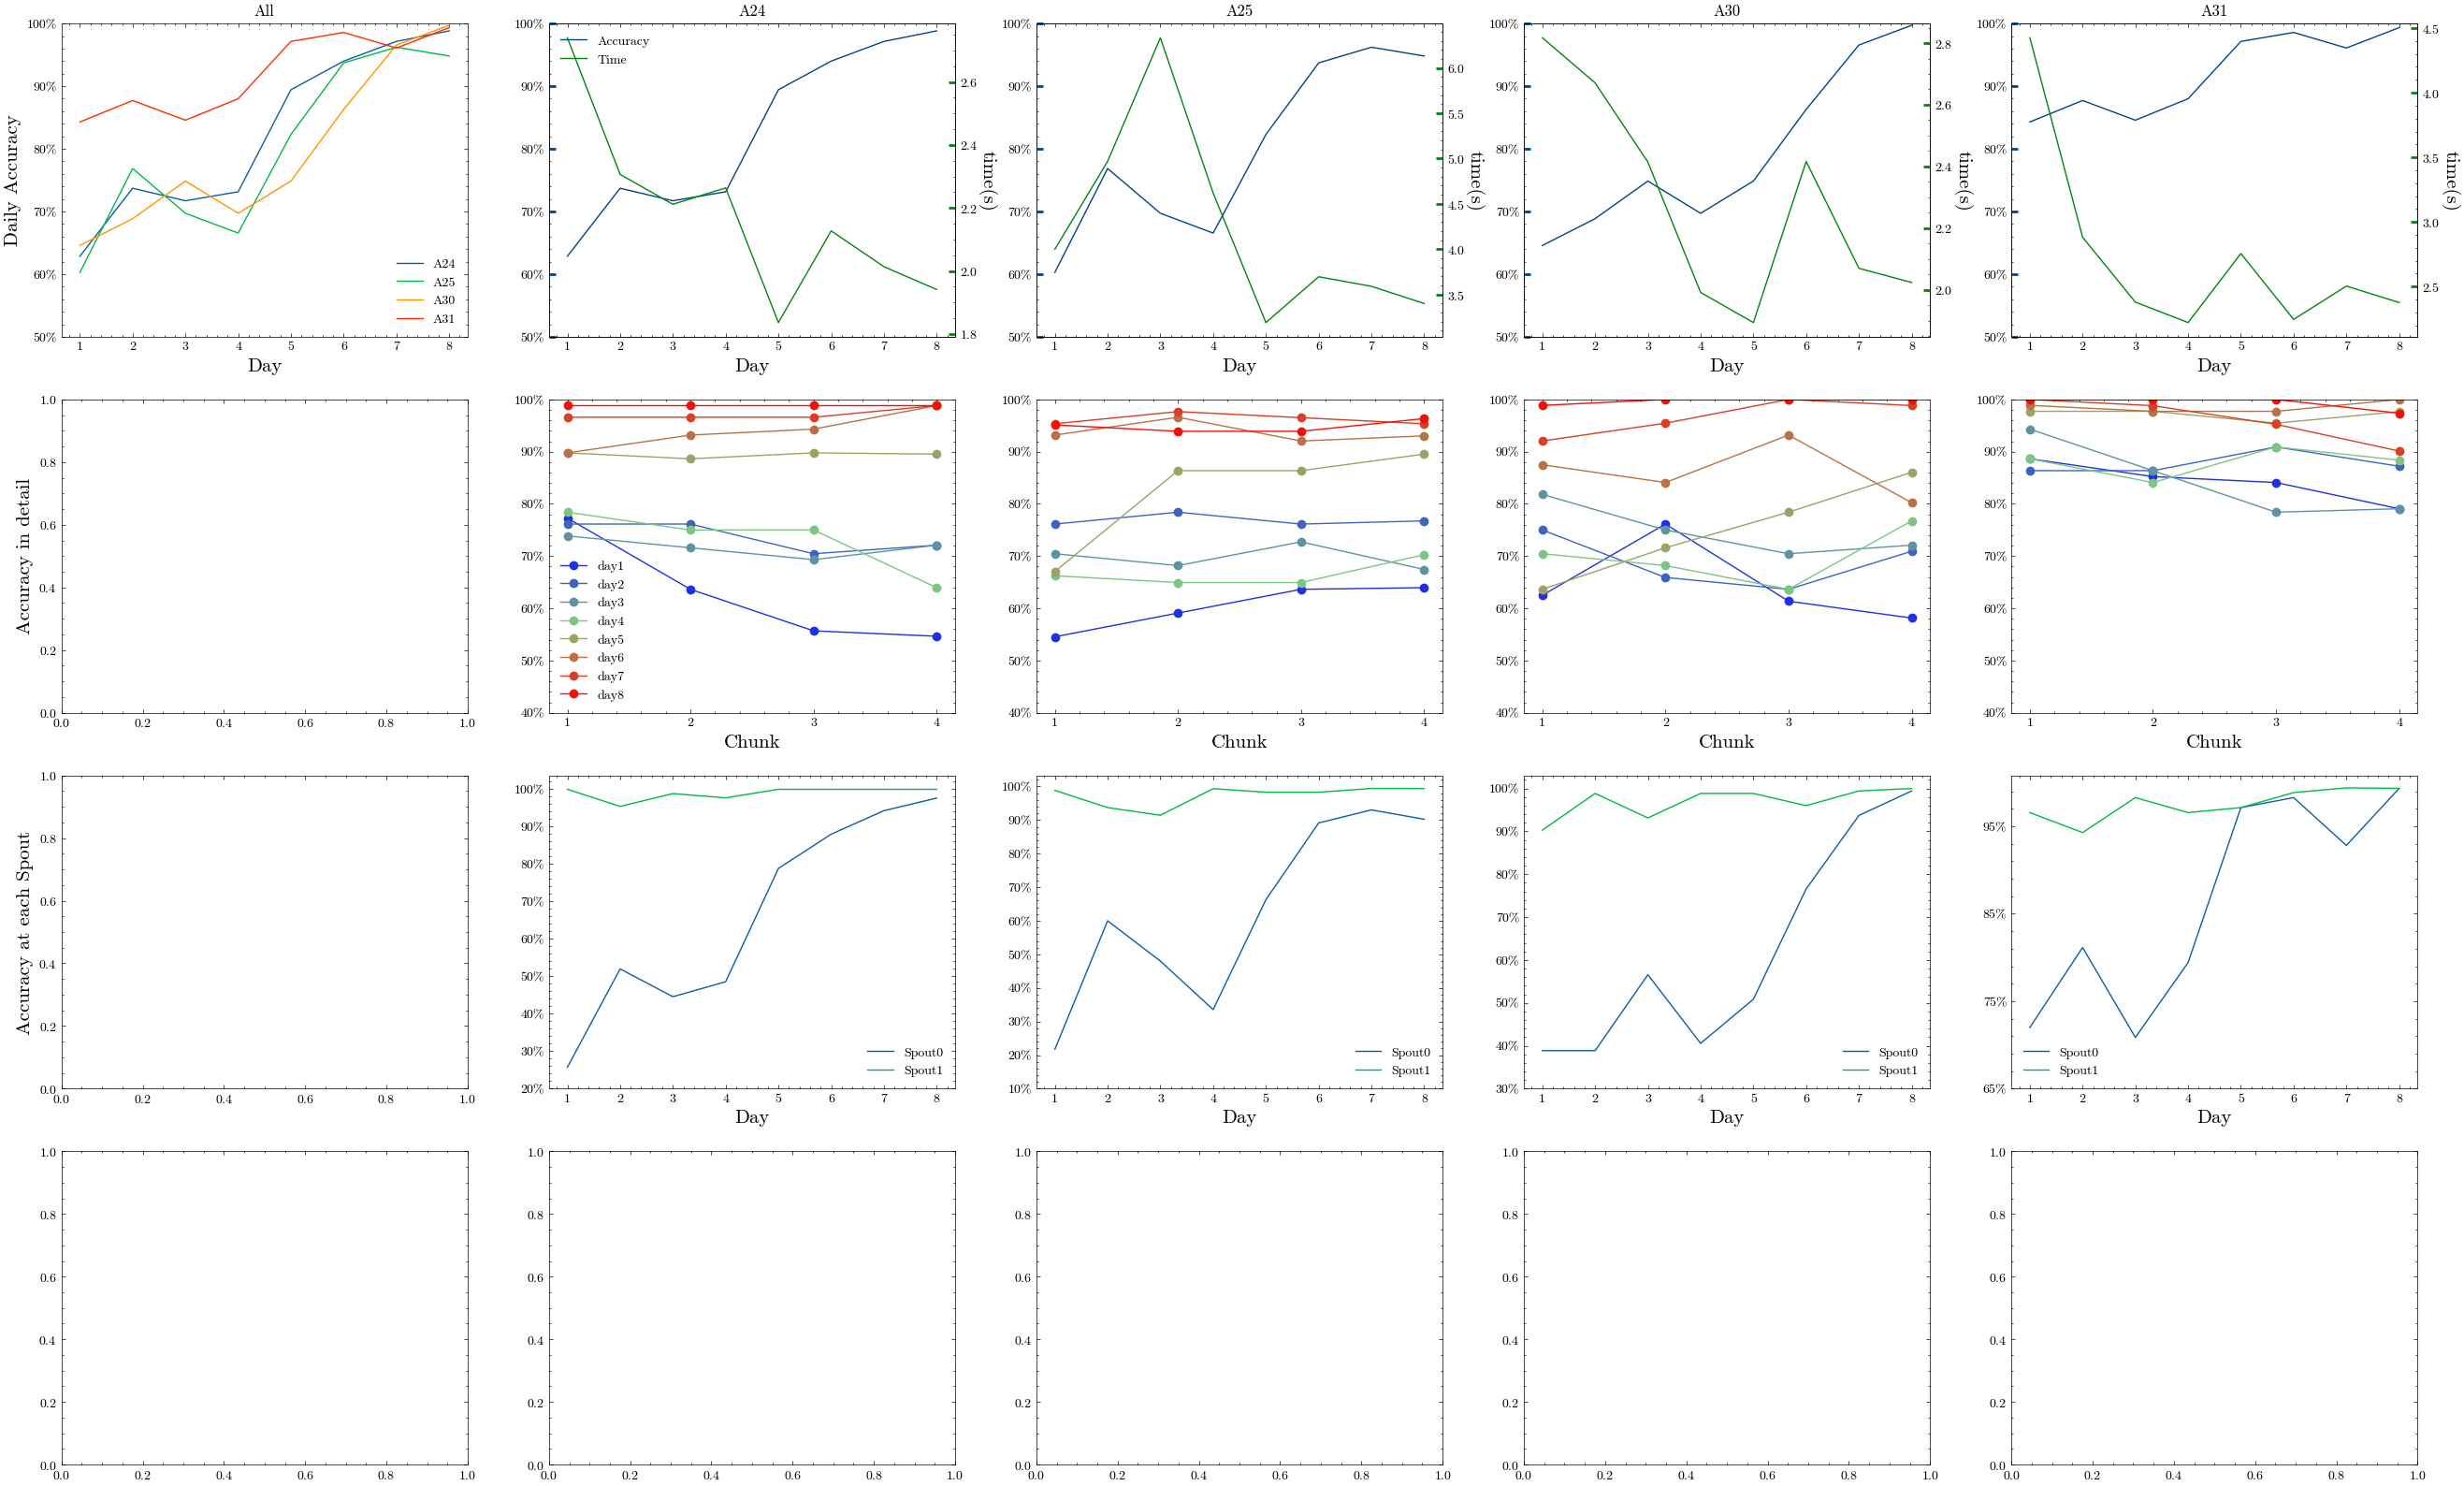

In [ ]:
import scienceplots
plt.style.use(['science', 'no-latex'])

fig, axes = plt.subplots(3, len(mouseNames)+1, figsize = ((len(mouseNames)+1) * 6.5, 20))


ResultsEverydayEveryMouse = []
TimeEverydayEveryMouse = []
for mouse in MouseRecords:
    ResultsEverydayEveryMouse.append(mouse.ReturnResults())
    tempMean = []
    for meandict in mouse.ReturnMean():
        tempMean.append(meandict["trialElapsedTimeMean"])
    TimeEverydayEveryMouse.append(tempMean)

for resultPerMouseInd in range(0, len(ResultsEverydayEveryMouse)):
    AccuracyInTotal = []
    for resultPerDay in ResultsEverydayEveryMouse[resultPerMouseInd]:
        AccuracyInTotal.append(np.sum(resultPerDay) / len(resultPerDay))

    tempAxe = axes[0][resultPerMouseInd + 1]
    _ap, = tempAxe.plot(AccuracyInTotal, label = "Accuracy", c = '#014485')
    # tempAxe.plot(np.ones(len(AccuracyInTotal)), linestyle = "--", c = "r")
    tempAxe.set_ylim(0.5, 1.0)
    tempAxe.tick_params('y', which = 'major', color = '#014485', width = 2, length = 5)
    # tempAxe.set_yticks([])
    tempAxe.set_title(mouseNames[resultPerMouseInd])
    tempXticks = []
    for i in range(1, len(AccuracyInTotal) + 1):
        tempXticks.append(str(i))
    tempAxe.set_xticks(range(len(AccuracyInTotal)), tempXticks)
    tempAxe.set_yticks(np.arange(0.5, 1.05, 0.1), [f"{int(np.round(value * 100))}%" for value in np.arange(0.5, 1.05, 0.1)])
    tempAxe.set_xlabel("Day", size = 15)

    # for _x in range(0, len(AccuracyInTotal)):
    #     tempAxe.annotate(f"{AccuracyInTotal[_x] * 100: .2f}%", (_x, AccuracyInTotal[_x]+0.03))

    axes[0][0].plot(AccuracyInTotal)
    axes[0][0].set_xticks(range(len(AccuracyInTotal)), tempXticks)
    axes[0][0].set_yticks(np.arange(0.5, 1.05, 0.1), [f"{int(np.round(value * 100))}%" for value in np.arange(0.5, 1.05, 0.1)])


    axeTime = tempAxe.twinx()
    _tp, = axeTime.plot(TimeEverydayEveryMouse[resultPerMouseInd], c = "#018511", label = "Time")
    axeTime.set_ylabel("time(s)", rotation = 270, labelpad = 15, size = 15)
    axeTime.tick_params('y', which = 'major', color = '#018511', width = 2, length = 5)


    if tempAxe == axes[0][1]:
        tempAxe.legend([_ap, _tp], [p.get_label() for p in [_ap, _tp]])

axes[0][0].set_ylabel("Daily Accuracy", rotation = 90, size = 15)
axes[0][0].set_xlabel("Day", size = 15)
axes[0][0].set_ylim(0.5, 1.0)
axes[0][0].set_title("All")
axes[0][0].legend(mouseNames)

#region Daily AccuracyChange in Detail
ResultsInGroupEverydayEveryMouse = []
for mouse in MouseRecords:
    ResultsInGroupEverydayEveryMouse.append(mouse.ReturnAccuracyInGroup())


DailyColor:list[str]=[]
for i in range(1, len(ResultsInGroupEverydayEveryMouse[0]) + 1):
    tempcolor = i * (255 // len(ResultsInGroupEverydayEveryMouse[0]))
    DailyColor.append(f"#{tempcolor:02X}{(205 - abs(205 - int(tempcolor * 1.6))):02X}{(255 - tempcolor):02X}")
for resultPerMouseInd in range(0, len(ResultsInGroupEverydayEveryMouse)):
    tempAxe = axes[1][resultPerMouseInd + 1]
    for Day in range(len(ResultsInGroupEverydayEveryMouse[resultPerMouseInd])):
        resultPerDay = ResultsInGroupEverydayEveryMouse[resultPerMouseInd][Day]
        # tempAxe.plot(np.ones(len(resultPerDay)), linestyle = "--", c = "r")
        tempAxe.plot(resultPerDay, 'o-', c = DailyColor[Day])
        

    if tempAxe == axes[1][1]:
        tempAxe.legend(["day" + str(i) for i in range(1, len(ResultsInGroupEverydayEveryMouse[resultPerMouseInd])+1)], loc = 3)
    tempAxe.set_ylim(0.4, 1.0)
    tempAxe.set_xticks(range(0, len(resultPerDay)), labels=[str(i) for i in range(1, len(resultPerDay)+1)])
    tempAxe.set_yticks(np.arange(0.4, 1.05, 0.1), [f"{int(np.round(value * 100))}%" for value in np.arange(0.4, 1.05, 0.1)])
    tempAxe.set_xlabel("Chunk", size = 15)

axes[1][0].set_ylabel("Accuracy in detail", rotation = 90, size = 15)

# MouseAndDayNeedToCheck = [[6], [5, 6], [4], [3]]
# tempNumInEachBin = ceil((maxTrials - ignoreFristTrials)/trialGroupCount)
# usedAxe = 0
# for mouse in range(len(MouseAndDayNeedToCheck)):
#     if len(MouseAndDayNeedToCheck[mouse])>0 and usedAxe <5:
#         for day in MouseAndDayNeedToCheck[mouse]:
#             tempResult = ResultsEverydayEveryMouse[mouse][day]
#             tempDayResutInGroup = [[], []]#[[succcessNum in group1, ...2, ...3], [failNum in group1, ...2, ...3]]
#             for i in range(0 , len(tempResult) , tempNumInEachBin):
#                 tempBin = np.array(tempResult[i:min(len(tempResult), i+tempNumInEachBin)])
#                 tempDayResutInGroup[0].append(len(tempBin[tempBin == 1]))
#                 tempDayResutInGroup[1].append(len(tempBin[tempBin == 0]))
#             axes[3][usedAxe].bar(range(trialGroupCount), tempDayResutInGroup[0], label = "success")
#             axes[3][usedAxe].bar(range(trialGroupCount), tempDayResutInGroup[1], bottom = tempDayResutInGroup[0], label = "fail")
#             axes[3][usedAxe].legend()
#             usedAxe += 1



#region Accuracy Per Spout
RightLickPosEverydayEveryMouse = []
for mouse in MouseRecords:
    RightLickPosEverydayEveryMouse.append(mouse.ReturnRightSpout())

for LickPosPerMouseInd in range(len(RightLickPosEverydayEveryMouse)):
    tempAxe = axes[2][LickPosPerMouseInd + 1]
    AccuracyPerSpout = [[], []]
    for LickPosPerDay in range(len(RightLickPosEverydayEveryMouse[LickPosPerMouseInd])):
        _tempLickPosReuslt = np.array(ResultsEverydayEveryMouse[LickPosPerMouseInd][LickPosPerDay])
        for Spout in range(2):
            _tempSpoutResult = _tempLickPosReuslt[(RightLickPosEverydayEveryMouse[LickPosPerMouseInd][LickPosPerDay]) == Spout]
            _temp_accuracy = np.sum(_tempSpoutResult)/len(_tempSpoutResult)
            AccuracyPerSpout[Spout].append(_temp_accuracy)
    tempAxe.plot(AccuracyPerSpout[0])
    tempAxe.plot(AccuracyPerSpout[1])
    tempXticks = []
    for i in range(1, len(AccuracyPerSpout[0]) + 1):
        tempXticks.append(str(i))
    tempAxe.set_xticks(range(len(AccuracyPerSpout[0])), tempXticks)
    tempyticks = tempAxe.get_yticks()
    tempAxe.set_yticks(np.arange(tempyticks[0], 1.05, 0.1), [f"{int(np.round(value * 100))}%" for value in np.arange(tempyticks[0], 1.05, 0.1)])

    tempAxe.set_xlabel("Day", size = 15)

    tempAxe.legend(["Spout0", "Spout1"])
    # tempAxe.set_ylim(0.5, 1)
    # tempAxe.set_title(mouseNames[LickPosPerMouseInd])

axes[2][0].set_ylabel("Accuracy at each Spout", rotation = 90, size = 15)

plt.show()